# Drug and Alcohol Related Police Action Over Time

**Note:** Throughout this, **I'm taking a p-value of 0.05 to indicate significance.**

Let's start by importing our data - this is included here so you can reproduce this, but you don't *really* need to go over all this.

In [95]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from scipy import optimize
from scipy.stats import ttest_1samp as ttest1Samp
from IPython.display import Markdown as md
import statsmodels.api as sm
from scipy.spatial import distance
plt.rcParams['figure.figsize'] = [18, 4]

In [96]:
df = pd.read_excel('./../Formatted-Data/safety_security_and_fire_reports.xlsx')
dfSplit = np.split(df, df[df.isnull().all(1)].index) #split by blank lines

In [97]:
def getByLoc(dfList, location):
    for i,dfi in enumerate(dfList):
        if i>0:
            dfi.columns = dfi.iloc[1]
            dfi=dfi[2:]
        dfi.dropna(how='all') # Drop columns with no data reported (:eyes: @ 2018)
        dfi = dfi.drop(columns="Notes") # Remove Notes
        if "Location" in dfi.columns:
            dfi = dfi[dfi['Location']==location]
            deleteRows = 2 # For rows after blank lines, need to delete an extra row
        else:
            deleteRows = 1
        dfi = dfi.T # Transpose Data
        dfi = dfi.dropna(how='all') # Drop rows with no data reported
        dfi.columns = dfi.iloc[0]
        dfi=dfi[deleteRows:]
        if "Burglary" in dfi.columns:
            dfi = dfi.drop(columns="Burglary") # See below!
        dfi.index = dfi.index.astype(int)
        dfList[i] = dfi
    return dfList

**Note:** I'm excluding burglary here as it's a large component of the overall crime, but wasn't collected/reported every year.

In [98]:
cats = ["Training", "Crime", "Arrest", "Discipline"]
locs = ["Campus", "Student Residences"]

ssfrData = {} 
for loc in locs:
    data = getByLoc(deepcopy(dfSplit), loc)
    for i, cat in enumerate(cats):       
        if not cat in ssfrData:
            ssfrData[cat] = {}
        ssfrData[cat][loc] = data[i]

For this analysis, I'm using arrests on *campus* which is defined by Stanford's report as:

**Campus:** "Any building or property owned or controlled by an institution within the same reasonably contiguous geographic area and used by the institution in direct support of, or in a manner related to, the institution’s educational purposes, including residence halls and Any building or property that is within or reasonably contiguous to paragraph (1) of this definition, that is owned by the institution but controlled by another person, is frequently used by students, and supports institutional purposes."

Why? While it's true that most student drinking happens in Student Residences, all arrests (save for 2014) made by the police aren't in Student Residences - it's really serving as a proxy for police enforcement anyways, so it should do just fine.

Just so we're clear, here are the other important definitions of the data types:

**Liquor Laws:** The violation of laws prohibiting the manufacture, sale, purchase, transportation, possession, or use of alcoholic beverages. Driving under the influence and drunkenness violations are excluded.

**Drug Laws:** Violations of laws relating to the unlawful possession, sale, use, growing, manufacturing, and making of narcotic drugs. The relevant substances include: opium or cocaine and their derivatives (morphine, heroin, codeine); marijuana; synthetic narcotics (Demerol, methadone); and dangerous non-narcotic drugs (barbiturates, Benzedrine).

If both an arrest and disciplinary referral are made, only the arrest is counted.

### Alright, enough! *Show me the data*

Crime,Murder/Non-negligent manslaughter,Negligent manslaughter,Robbery,Aggravated Assult,Theft-Motor Vehicles and Golf Carts,Arson,Rape,Fondling,Incest,Statutory Rape,Total Sex Offenses,Dating Violence,Domestic Violence,Stalking,Hate Crimes,Total Crime,Total Non Sex Offense Crime
6,,,,,,,,,,,,,,,,,
2009,0,0,2,5,15,1,4,4,0,0,10,NaN,6,2,1,50.0,40
2010,0,0,1,4,14,1,13,4,4,0,21,NaN,5,0,2,69.0,48
2011,0,0,1,2,19,5,5,3,3,0,11,NaN,4,0,1,54.0,43
2012,0,0,1,8,12,0,16,7,3,0,26,NaN,11,1,0,85.0,59
2013,0,0,2,3,17,0,16,10,0,0,26,2,8,6,0,90.0,64
2014,0,0,0,9,20,0,26,4,0,0,30,0,10,13,3,115.0,85
2015,0,0,0,0,36,0,25,11,0,2,38,1,10,18,2,143.0,105
2016,0,0,0,3,33,2,33,12,0,0,46,0,8,21,8,166.0,120
2017,0,0,2,1,30,0,15,24,0,0,39,0,7,12,22,152.0,113


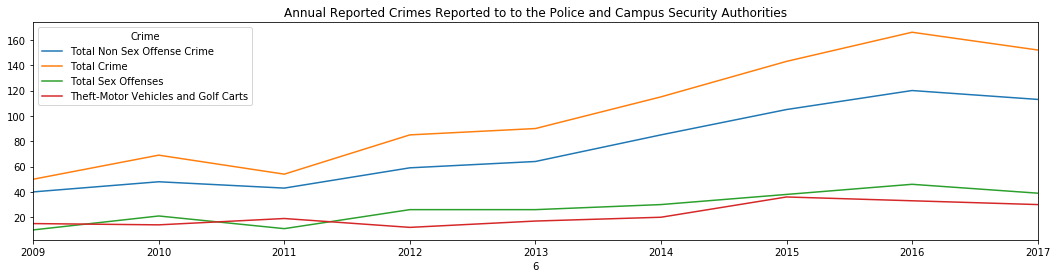

In [99]:
ssfrData["Crime"]["Campus"]['Total Crime'] = ssfrData["Crime"]["Campus"][list(ssfrData["Crime"]["Campus"].columns)[1:]].sum(axis=1)
ssfrData["Crime"]["Campus"]['Total Non Sex Offense Crime'] = ssfrData["Crime"]["Campus"]["Total Crime"] - ssfrData["Crime"]["Campus"]["Total Sex Offenses"]
crimesOfInterest = ["Total Non Sex Offense Crime","Total Crime", "Total Sex Offenses", "Theft-Motor Vehicles and Golf Carts"]
display(ssfrData["Crime"]["Campus"])
ssfrData["Crime"]["Campus"].loc[:, crimesOfInterest].plot(legend=True, title="Annual Reported Crimes Reported to to the Police and Campus Security Authorities")

Arrests,Liquor Law,Drug Violations,Weapon Possession
40,,,
2009,113,45,2
2010,31,27,1
2011,40,17,2
2012,52,6,2
2013,89,9,4
2014,38,6,2
2015,70,17,4
2016,62,17,5
2017,26,10,9


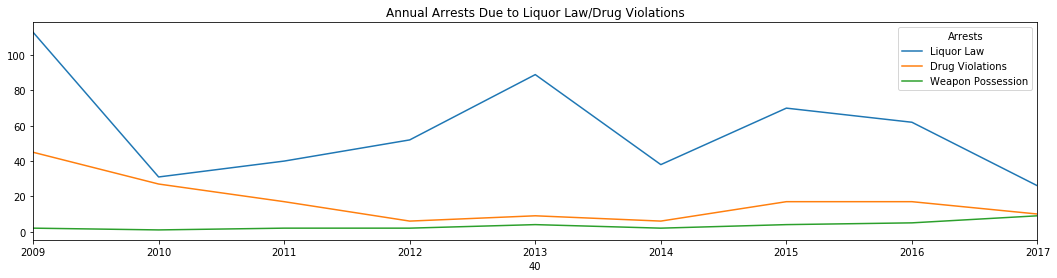

In [100]:
arrestsOfInterest = ['Liquor Law', 'Drug Violations', "Weapon Possession"]
display(ssfrData["Arrest"]["Campus"].loc[:, arrestsOfInterest])
ssfrData["Arrest"]["Campus"].loc[:, arrestsOfInterest].plot(title="Annual Arrests Due to Liquor Law/Drug Violations")

*Exciting!* But for this to be useful, let's control for population - one would expect that crimes go up when population goes up.

In [101]:
demoDf = pd.read_excel('./../Formatted-Data/student_demographics.xlsx', sheet_name="Students Housed on Campus")

types = ["Undergraduate","Graduate"]

demog = {} 
for typ in types:
    demoTwo = deepcopy(demoDf)
    demoTwo = demoTwo[demoTwo['Student Type']==typ]
    demoTwo = demoTwo.T
    demoTwo.columns = demoTwo.iloc[1]
    demoTwo=demoTwo[2:]
    demog[typ] = demoTwo
totalDemog = demog[types[0]]

for col in totalDemog.columns:
    totalDemog.rename(columns={col: types[0] +"s "+col}, inplace=True)
for typ in types:
    for col in demog[typ].columns:
        totalDemog[typ +"s "+col] = demog[typ][col]
totalDemog["Total Housed on Campus"] = totalDemog["Undergraduates Housed on Campus"] + totalDemog["Graduates Housed on Campus"] 

Since the *weird* stanford pdf I found with the population data (annual snapshots, as of fall quarter of each academic year) (which *is* meaningfully different than draw data for reasons I'm not 100% clear on) only goes up to 2015-2016, let's estimate 2016-2017:

In [102]:
housed = list(totalDemog["Total Housed on Campus"])
X = sm.add_constant([x+1 for x in range(0, len(housed))])
model = sm.OLS(housed, X)
results = model.fit()
display(results.params)
totalDemog["Total Housed on Campus"].loc["2016-2017"] = len(housed)*results.params[1]+results.params[0]

array([10244.2       ,   126.10909091])

As expected, total population is increasing:

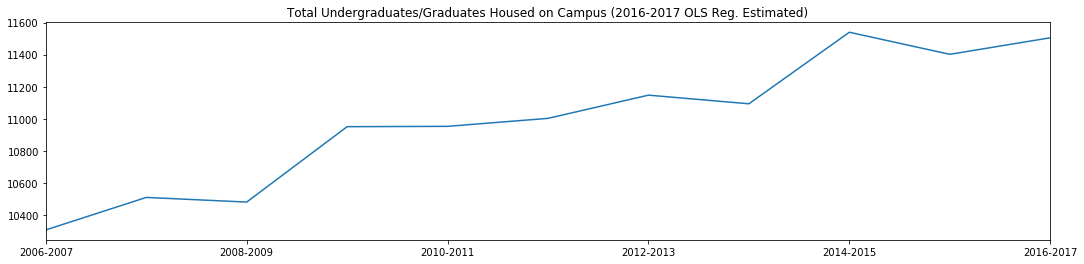

In [103]:
totalDemog["Total Housed on Campus"].plot(title="Total Undergraduates/Graduates Housed on Campus (2016-2017 OLS Reg. Estimated)")

Side note: The police data is collected each calendar year while the population data is a snapshot in the fall - not mentioning summer population's deviation from the rest of the year. All considering, it still makes sense to use this a proxy for number of people, as it's likely that year to year fall population is approximately linearally porportional to any given specific point of the year *but* I want to point out that's it's a proxy, and not the actuall numbers.

Let's go ahead and weight the data, and while we're at it, let's look at the change over time - this is something much easier to work with than the raw data.

In [104]:
def getAnnChange(df, col1):
    d = []
    for index, row in df.iterrows():
        if d==[]:
            d.append(np.nan)
            oldRow = row[col1]
        else:
            d.append(row[col1]-oldRow)
    return d
def getWeightedVal(df, col1):
    d = []
    for index, row in df.iterrows():
        index = str(int(index))
        pop = int(totalDemog["Total Housed on Campus"][str(int(index)-1)+"-"+index])
        d.append(row[col1]/pop)
    return d
def addFuncCol(df, func, col, newName):
    df[newName] = func(df, col)
def dName(var):
    return "Change in "+ var +" Since Previous Year"
def wName(var):
    return "Weighted "+ var +" By Campus Population"
for arrest in arrestsOfInterest:
    addFuncCol(ssfrData["Arrest"]["Campus"], getWeightedVal, arrest, wName(arrest))
    addFuncCol(ssfrData["Arrest"]["Campus"], getAnnChange, wName(arrest), dName(wName(arrest)))
for crime in crimesOfInterest:
    addFuncCol(ssfrData["Crime"]["Campus"], getWeightedVal, crime, wName(crime))
    addFuncCol(ssfrData["Crime"]["Campus"], getAnnChange, wName(crime), dName(wName(crime)))

## Data Weighted by Population, Changes Over Time

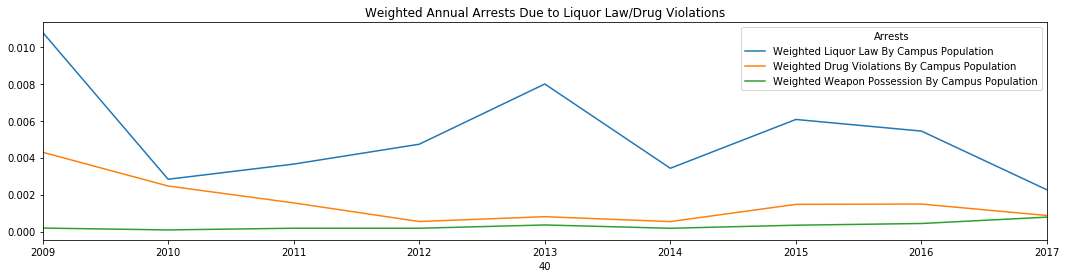

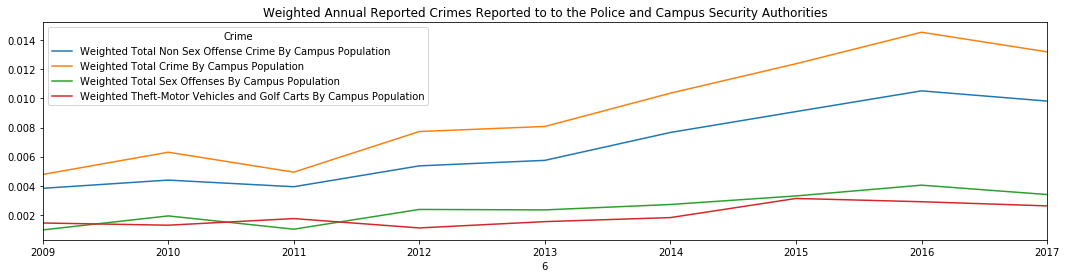

In [105]:
wArrestsOfInterest = list(map(wName, arrestsOfInterest))
wCrimesOfInterest = list(map(wName, crimesOfInterest))
ssfrData["Arrest"]["Campus"].loc[:, wArrestsOfInterest].plot(title="Weighted Annual Arrests Due to Liquor Law/Drug Violations")
ssfrData["Crime"]["Campus"].loc[:, wCrimesOfInterest].plot(title="Weighted Annual Reported Crimes Reported to to the Police and Campus Security Authorities")

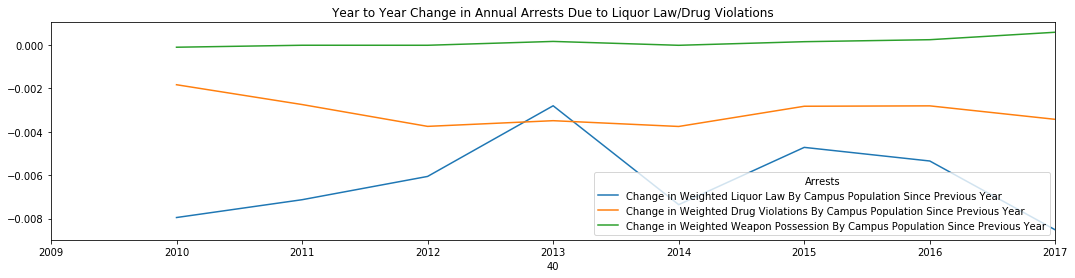

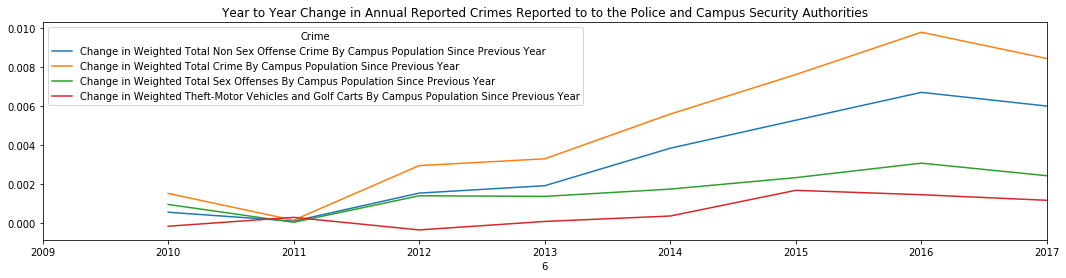

In [106]:
dwArrestsOfInterest = list(map(dName, map(wName, arrestsOfInterest)))
dwCrimesOfInterest = list(map(dName, map(wName, crimesOfInterest)))
ssfrData["Arrest"]["Campus"].loc[:, dwArrestsOfInterest].plot(title="Year to Year Change in Annual Arrests Due to Liquor Law/Drug Violations")
ssfrData["Crime"]["Campus"].loc[:, dwCrimesOfInterest].plot(title="Year to Year Change in Annual Reported Crimes Reported to to the Police and Campus Security Authorities")

## Show Me Those p-Values Baby 

In [107]:
dwTotalCrime = ssfrData["Crime"]["Campus"].loc[:, dName(wName("Total Crime"))][1:]
tcrimet = ttest1Samp(dwTotalCrime,0)
dwDrug = ssfrData["Arrest"]["Campus"].loc[:, dName(wName("Drug Violations"))][1:]
drugt = ttest1Samp(dwDrug,0)
dwLiq = ssfrData["Arrest"]["Campus"].loc[:, dName(wName("Liquor Law"))][1:]
liqt = ttest1Samp(dwLiq,0)

Putting things in a readable format:

In [108]:
def formatP(p):
    if p< 0.0001:
        return "<0.0001"
    else:
        return round(p, 4)
def sign(stat, verbose=True):
    if stat<0:
        return "Negative" if verbose else "-"
    elif stat>0:
        return "Positive" if verbose else "+"
    return stat
md(("|Test (Null Hypothesis)|p-value|Statistic (mean) Sign |Which implies|\n"+
   "|-|-|-|-|\n"+
   "|Annual Change in Population Adjusted Total Reported Crime is 0 | {tcrimet}|{tcrimesign}|Reported Crime is **Increasing**| \n"+
   "|Annual Change in Population Adjusted Liquor Law Arrests is 0 | {liqt}|{liqsign}|Liquor Law Arrests are **Decreasing**| \n"+
   "|Annual Change in Population Adjusted Drug Violation Arrests is 0 | {drugt}|{drugsign}|Drug Violation Arrests are **Decreasing**| \n"+
   "").format(liqt=formatP(liqt.pvalue),liqsign=sign(liqt.statistic),
              tcrimet=formatP(tcrimet.pvalue),tcrimesign=sign(tcrimet.statistic),
              drugt=formatP(drugt.pvalue),drugsign=sign(drugt.statistic)))

|Test (Null Hypothesis)|p-value|Statistic (mean) Sign |Which implies|
|-|-|-|-|
|Annual Change in Population Adjusted Total Reported Crime is 0 | 0.0051|Positive|Reported Crime is **Increasing**| 
|Annual Change in Population Adjusted Liquor Law Arrests is 0 | <0.0001|Negative|Liquor Law Arrests are **Decreasing**| 
|Annual Change in Population Adjusted Drug Violation Arrests is 0 | <0.0001|Negative|Drug Violation Arrests are **Decreasing**| 


Hm. But what if this is just to do reporting biases? Well, let's take a look at Total *Non Sex Offence* Crime to remove the largest bias from recent increases in sex offence reporting and while we're at it let's look at Weapon Possession arrests to make sure arrests in general aren't decreasing.

In [109]:
dwTotalNSOCrime = ssfrData["Crime"]["Campus"].loc[:, dName(wName("Total Non Sex Offense Crime"))][1:]
nsocrimet = ttest1Samp(dwTotalNSOCrime,0)
dwWeap = ssfrData["Arrest"]["Campus"].loc[:, dName(wName("Weapon Possession"))][1:]
weapt = ttest1Samp(dwWeap,0)

md(("|Test (Null Hypothesis)|p-value|Statistic (mean) Sign |Which implies|\n"+
   "|-|-|-|-|\n"+
   "|Annual Change in Population Adjusted Total Reported Crime is 0 | {nsocrimet}|{nsocrimesign}|Reported Non Sex Offence Crime is **Increasing**| \n"+
   "|Annual Change in Population Adjusted Weapon Posession Arrests is 0 | {weapt}|{weapsign} (Non-significant)|Weapon Possesion Arrests are **About the Same**| \n"+
   "").format(weapt=formatP(weapt.pvalue),weapsign=sign(weapt.statistic),
              nsocrimet=formatP(nsocrimet.pvalue),nsocrimesign=sign(nsocrimet.statistic)))

|Test (Null Hypothesis)|p-value|Statistic (mean) Sign |Which implies|
|-|-|-|-|
|Annual Change in Population Adjusted Total Reported Crime is 0 | 0.0088|Positive|Reported Non Sex Offence Crime is **Increasing**| 
|Annual Change in Population Adjusted Weapon Posession Arrests is 0 | 0.1405|Positive (Non-significant)|Weapon Possesion Arrests are **About the Same**| 


And, tying everything together while very conservatively adjusting for multiple tests with via a [Bonferroni Correction](http://mathworld.wolfram.com/BonferroniCorrection.html):

In [110]:
def bonferroniCor(stat, ntests):
    return stat*ntests

nTests = 5

This correction is overkill, as these data sets aren't *really* independant. Since Total Reported Crime and Total Non Sex Offence Reported Crime are *so* related (not to mention Drug Violations and Liquor Law Arrests), I'm going to set nTests at 5 (which includes a future test on the same data that's coming in a bit).

In [111]:
def sig(pvalue, text=True, nTests=1):
    if bonferroniCor(pvalue, nTests) < 0.05:
        return "Yes" if text else True
    return "No" if text else False

display(md(("|Test (Null Hypothesis)|Adj. p-value|Significant|Statistic (mean) Sign |Which implies|\n"+
   "|-|-|-|-|-|\n"+
   "|Annual Change in Population Adjusted Total Reported Crime is 0 | {tcrimet}|**{tcrimesig}**|{tcrimesign}|Reported Crime is **Increasing**| \n"+
   "|Annual Change in Population Adjusted Liquor Law Arrests is 0 | {liqt}|**{liqsig}**|{liqsign}|Liquor Law Arrests are **Decreasing**| \n"+
   "|Annual Change in Population Adjusted Drug Violation Arrests is 0 |{drugt}|**{drugsig}**|{drugsign}|Drug Violation Arrests are **Decreasing**| \n"+
   "|Annual Change in Population Adjusted Total Non Sex Offence Reported Crime is 0 |{nsocrimet}|**{nsocrimesig}**|{nsocrimesign}|Reported Non Sex Offence Crime is **Increasing**| \n"+
   "|Annual Change in Population Adjusted Weapon Posession Arrests is 0 |{weapt}|**{weapsig}**|{weapsign}|Weapon Possesion Arrests are **About the Same**| \n"+
   "").format(weapt=formatP(bonferroniCor(weapt.pvalue, nTests)),weapsig=sig(weapt.pvalue, nTests=nTests),weapsign=sign(weapt.statistic),
              nsocrimet=formatP(bonferroniCor(nsocrimet.pvalue, nTests)),nsocrimesig=sig(nsocrimet.pvalue, nTests=nTests),nsocrimesign=sign(nsocrimet.statistic), 
              liqt=formatP(bonferroniCor(liqt.pvalue, nTests)),liqsig=sig(liqt.pvalue, nTests, nTests=nTests),liqsign=sign(liqt.statistic),
              tcrimet=formatP(bonferroniCor(tcrimet.pvalue, nTests)),tcrimesig=sig(tcrimet.pvalue, nTests=nTests),tcrimesign=sign(tcrimet.statistic),
              drugt=formatP(bonferroniCor(drugt.pvalue, nTests)),drugsig=sig(drugt.pvalue, nTests=nTests),drugsign=sign(drugt.statistic))))

|Test (Null Hypothesis)|Adj. p-value|Significant|Statistic (mean) Sign |Which implies|
|-|-|-|-|-|
|Annual Change in Population Adjusted Total Reported Crime is 0 | 0.0257|**Yes**|Positive|Reported Crime is **Increasing**| 
|Annual Change in Population Adjusted Liquor Law Arrests is 0 | 0.0002|**Yes**|Negative|Liquor Law Arrests are **Decreasing**| 
|Annual Change in Population Adjusted Drug Violation Arrests is 0 |<0.0001|**Yes**|Negative|Drug Violation Arrests are **Decreasing**| 
|Annual Change in Population Adjusted Total Non Sex Offence Reported Crime is 0 |0.0441|**Yes**|Positive|Reported Non Sex Offence Crime is **Increasing**| 
|Annual Change in Population Adjusted Weapon Posession Arrests is 0 |0.7027|**No**|Positive|Weapon Possesion Arrests are **About the Same**| 


## But what does this *mean*? (no pun indended, I swear)

Well, we can be pretty certain that general crime is increasing and that general drug/liquor arrests are decreasing (but likely not arrests generally (see Weapon Posession)). Why? That's a good question. There's a few possibilities:

1. Alcohol/Drug use has gone down and by proxy there are fewer arrests
2. Alcohol/Drug use has stayed the same/gotten more prevalent and
    - Police aren't enforcing policy as stringently as before (non-specifically)
    - Police aren't enforcing drug specific policies as stringently as before
    - People are hiding their activity better (eg. just not getting caught)
    - People are being reprimanded in a way not captured by these numbers

Well, let's go through it.

## Is a Decrease in Alcohol/Drug Use The Reason For Less Arrests?

Let's look to the recent Alcohol Trends Report:

In [112]:
alcdf = pd.read_excel('./../Formatted-Data/alcohol_trends_report_2018.xlsx', sheet_name="ALCOHOL USE TRENDS, 2012-2018", index_col=[0,1])
alcdf = alcdf.drop(columns="Notes") # Remove Notes
alcdf = alcdf.T
display(alcdf)

Question/Prompt Binge Drinking Frequency (%)                          \
Answer                      10 or more times 1-9 times 0 times Blank   
2012                                     0.3      40.3    58.7   0.7   
2013                                     0.7      39.6    59.3   0.4   
2014                                     0.2      41.3    58.4     0   
2015                                     0.7      34.1    64.7   0.5   
2016                                     0.2      41.7    57.1     1   
2017                                       0      39.4    30.8  29.8   
2018                                     0.2      36.5    32.1  31.2   

Question/Prompt                   Average Number of Drinks per Week (%)  \
Answer          Total Respondents                                   15+   
2012                          583                                     5   
2013                          548                                     6   
2014                          438                                     4   
2015                          428                                     3   
2016                          902                                     5   
2017                          977                                     5   
2018                          825                                     5   

Question/Prompt                               ...  \
Answer          7.5 to 14 > 0 to 7   0 Blank  ...   
2012                   12       44  38     1  ...   
2013                   11       50  33     1  ...   
2014                   11       47  37     0  ...   
2015                   11       52  33     1  ...   
2016                   11       56  27     1  ...   
2017                    9       56  29   0.5  ...   
2018                    8       56  11    20  ...   

Question/Prompt Vomiting in Previous 30 Days (%)                  \
Answer                                     Blank Total Responces   
2012                                         NaN             NaN   
2013                                         NaN             NaN   
2014                                         NaN             NaN   
2015                                         0.9             428   
2016                                         1.1             902   
2017                                          30             977   
2018                                        31.4             825   

Question/Prompt Memory Loss in Previous 30 Days (%)                      \
Answer                             10 or more times 4-6 times 1-3 times   
2012                                            NaN       NaN       NaN   
2013                                            NaN       NaN       NaN   
2014                                            NaN       NaN       NaN   
2015                                              0       0.7       8.2   
2016                                              0       0.6       8.9   
2017                                            0.1       0.4       7.8   
2018                                              0       0.5       8.6   

Question/Prompt                                                                
Answer          0 times Blank Total Responces Total Responces Total Responces  
2012                NaN   NaN             NaN             NaN             NaN  
2013                NaN   NaN             NaN             NaN             NaN  
2014                NaN   NaN             NaN             NaN             NaN  
2015               90.4   0.5             428             NaN             NaN  
2016               89.7   0.8             902             NaN             NaN  
2017               71.7  29.9             977             NaN             NaN  
2018               59.4  31.3             825             NaN             NaN  

[7 rows x 40 columns]

Okay, we've got a few metrics here for measuring "liquor use":
 - Binge Drinking Frequency in Past Two Weeks
 - Average Number of Drinks per Week
 - Binge Drinking in Past Two Weeks
 - Vomiting in Previous 30 Days
 - Hangover in Previous 30 Days
 - Memory Loss in Previous 30 Days
 - Emergency Transports

Wait. What's the difference between "Binge Drinking Frequency in Past Two Weeks" and "Binge Drinking in Past Two Weeks"?
 
Hm. Let's see.


"Binge Drinking Frequency in Past Two Weeks" represents 
 > the percentage of respondents who had: 1) not consumed more than five drinks per sitting in the past two weeks (Core) or greater than five drinks per sitting for men or greater than four drinks per sitting for women in the past two weeks (OAPE); 2) done so between 1 and 9 times; and 3) done so 10 or more times.

Whereas "Binge Drinking in Past Two Weeks" represents 
> Binge Drinking in Past Two Weeks, based on OAPE Data 

 and it
 > shows the frequencies of binge drinking in greater detail according to OAPE survey for 2015-2018. 38.8% (n=3132) of students reported having engaged in binge drinking at least once in the previous two weeks.
 
 So the real difference seems to only be accuracy/data source, and one only has results for 2015-2018. Great.
 
 Even better, 
 
 > Blank responses increased in 2017 and 2018 because those who responded as nondrinkers to a previous question did not see this question. Data taken from multiple sources, see pdf for elaboration. Binge drinking generally is defined as four or more drinks for [AFAB]s or five or more drinks for [AMAB]s per sitting.

So, with all that, let's start by assuming that all blank answers are actually 0 responces, and we can take a look at how similar these two data sets are.

In [113]:
bingeQs = ["Binge Drinking Frequency (%)", "Binge Drinking in Past Two Weeks (%)"]

Answer,10 or more times,1-9 times,0 times,Blank,Total Respondents,0 times adj.
2012,0.3,40.3,58.7,0.7,583,59.4
2013,0.7,39.6,59.3,0.4,548,59.7
2014,0.2,41.3,58.4,0,438,58.4
2015,0.7,34.1,64.7,0.5,428,65.2
2016,0.2,41.7,57.1,1,902,58.1
2017,0,39.4,30.8,29.8,977,60.6
2018,0.2,36.5,32.1,31.2,825,63.3


Answer,10 or more times,7-9 times,4-6 times,1-3 times,0 times,I am a non-drinker,Blank,Total Responces,1-9 times,0 times adj.
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,<0.7,0.5,4.7,29,64.7,N/G,0.5,428,34.2,65.2
2016,<0.7,1.3,5.3,35,57.1,N/G,1,902,41.6,58.1
2017,<0.7,0.9,5.5,33,30.7,0.01,29.8,977,39.4,60.5
2018,<0.7,0.6,4.5,31.4,32.1,N/G,31.2,825,36.5,63.3


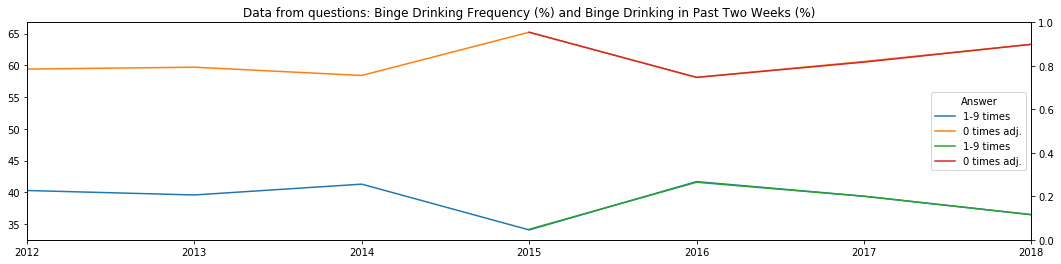

In [114]:
alcdf[bingeQs[1], "1-9 times"] = alcdf[bingeQs[1]]["7-9 times"]+alcdf[bingeQs[1]]["4-6 times"]+alcdf[bingeQs[1]]["1-3 times"]
ax = plt.gca()
ax2 = ax.twinx()
for question in bingeQs:
    alcdf[question, "0 times adj."] = alcdf[question]["0 times"] + alcdf[question]["Blank"]
    display(alcdf[question])
    alcdf[question].loc[:, ["1-9 times", "0 times adj."]].plot(legend=True, title="Data from questions: "+bingeQs[0]+" and "+bingeQs[1], ax=ax)
plt.show()

Hm. Interesting - the data fit's eachother *really* well. I'd gander that this is actually from the same data set and that there might be some trickery going on (eg. there might be more percise data from previous years available/a mistake was made somewhere - why dosen't the OAPE have data like this from 2012-2014?). Anyways, this is good - we know now that the two data sets can be used together, and they're either both innacurate or both accurate.

Let's take a look at the distributions - if they're normal, it makes sense for Stanford to only collect aggegate statistics.

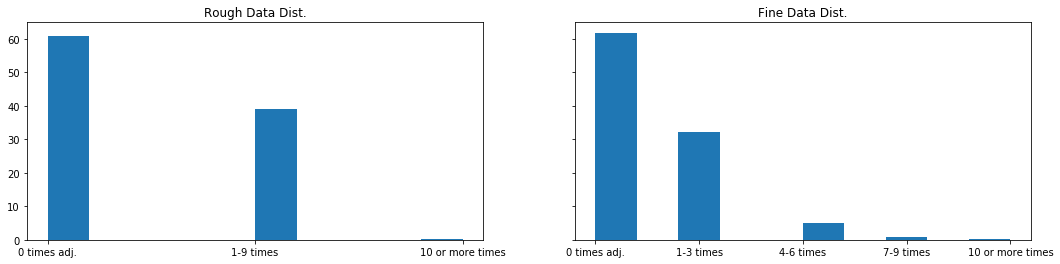

In [115]:
roughOptions = ["0 times adj.", "1-9 times", "10 or more times"]
fineOptions = ["0 times adj.", "1-3 times", "4-6 times", "7-9 times", "10 or more times"]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.figsize = [40, 5]
ax1.set_title("Rough Data Dist.")
ax2.set_title("Fine Data Dist.")
ax1.hist(roughOptions, weights=[alcdf[bingeQs[0]][opt].mean() for opt in roughOptions])
ax2.hist(fineOptions, weights=[alcdf[bingeQs[1]][opt].replace("<0.7", 0.4/3).astype(float).mean() for opt in fineOptions])
plt.show()
plt.close()

**Yikes.** 

That's not normal at all (which is exactly what we'd hope for health wise, but is does make the stats harder). So much for """"" INSERT AVG EST TECHNIQUE HERE """". In fact, just to take a look at just *how* bad the estimation would be, I ran the numbers, and the picture isn't pretty:

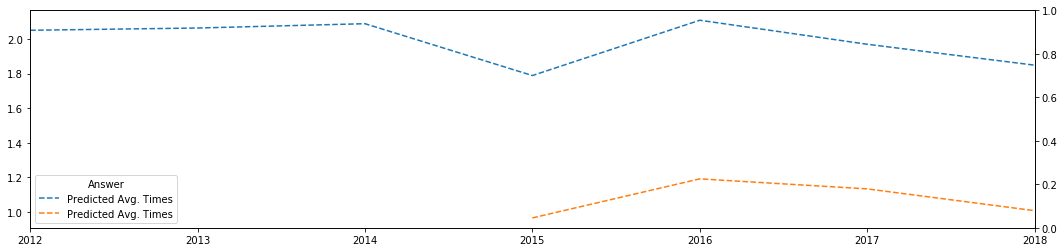

In [116]:
alcdf[bingeQs[1], "Predicted Avg. Times"] = ((alcdf[bingeQs[1]]["10 or more times"].replace("<0.7", 0.4/3))*12 + 
                                            alcdf[bingeQs[1]]["7-9 times"]*8 +
                                            alcdf[bingeQs[1]]["4-6 times"]*7 +
                                            alcdf[bingeQs[1]]["1-3 times"]*2)/100
alcdf[bingeQs[0], "Predicted Avg. Times"] = (alcdf[bingeQs[0]]["10 or more times"]*12 + 
                                            alcdf[bingeQs[0]]["1-9 times"]*5)/100
ax = plt.gca()
ax2 = ax.twinx()
typ = ["Fine", "Course"]
for i, question in enumerate(bingeQs):
    #alcdf[question, "0 times adj."] = alcdf[question]["0 times"] + alcdf[question]["Blank"]
    #display(alcdf[question])
    #alcdf[question].loc[:, ["1-9 times", "0 times adj."]].plot(legend=True, title="Data from questions: "+bingeQs[0]+" and "+bingeQs[1], ax=ax2)
    alcdf[question].loc[:, ["Predicted Avg. Times"]].plot(label="Predicted Avg. Times from "+typ[i]+" Data", legend=True, style="--", ax=ax)
plt.show()
avgPercentDifference = (100*(alcdf[bingeQs[0]].loc[:, ["Predicted Avg. Times"]]-
                             alcdf[bingeQs[1]].loc[:, ["Predicted Avg. Times"]])/
                        alcdf[bingeQs[1]].loc[:, ["Predicted Avg. Times"]]).mean()

In [117]:
md("That's on average a "+str(round(float(avgPercentDifference),2))+" percent over estimation! If the true average was 3 times every two weeks, this would lead someone to belive that the average is really 6 times - that's a big difference. This is one reason why Stanford should release as detailed data as they can - it's in their favor that we get the correct picture -- 4 times vs 8.")

That's on average a 79.99 percent over estimation! If the true average was 3 times every two weeks, this would lead someone to belive that the average is really 6 times - that's a big difference. This is one reason why Stanford should release as detailed data as they can - it's in their favor that we get the correct picture -- 4 times vs 8.

Let's start with some math. The true distribution can be described as:

Times Binged In the Last Week = P$\sum_{n=0}^\infty\beta_n n$ where $P$ is the total population, $n$ is the number of times binged associated with a percent $\beta_n$ of occrence in the past two weeks.

Since it's probably impossible for someone to binge an infinite amount in a week, we can change the bounds to reflect reality. And, since most people (<=0.7%) don't binge 10 or more times a week, we can simplify to $P\sum_{n=0}^{9}\beta_n n +P\sum_{n=10}^\infty\beta_n n = P\sum_{n=0}^{9}\beta_n n + B_{10+}P$. However, we run into issues when we try to bin things more.

Dividing by population ($P$) to just compute the average, this is what we get for the "fine" data:

$$\beta_1+\beta_22+\beta_33+\beta_44+\beta_55+\beta_66+\beta_77+\beta_88+\beta_99 + B_{10+}$$

$$(\beta_1+\beta_2+\beta_3)\left(\frac{\beta_1}{(\beta_1+\beta_2+\beta_3)}1+\frac{\beta_2}{(\beta_1+\beta_2+\beta_3)}2+\frac{\beta_3}{(\beta_1+\beta_2+\beta_3)}3\right) + ... + B_{10+}$$
where 
$\left(\frac{\beta_1}{(\beta_1+\beta_2+\beta_3)}1+\frac{\beta_2}{(\beta_1+\beta_2+\beta_3)}2+\frac{\beta_3}{(\beta_1+\beta_2+\beta_3)}3\right)$ is some number 1-3 that represents the average number of times in the 1-3 range that people binge in the past two weeks - data not given by any of stanford's reports (only $(\beta_1+\beta_2+\beta_3)$ like numbers are collected). However, $\beta_1$-$\beta_9$ are what we're really interested in. The situation however, is worse in the rouger data. Our situation is to the fine data as the fine data is to the actuall population:

$$(\beta_1+\beta_2+\beta_3+\beta_4+\beta_5+\beta_6+\beta_7+\beta_8+\beta_9)\left(\frac{\beta_1}{(\beta_1+\beta_2+\beta_3+\beta_4+\beta_5+\beta_6+\beta_7+\beta_8+\beta_9)}1+\frac{\beta_2}{(\beta_1+\beta_2+\beta_3+\beta_4+\beta_5+\beta_6+\beta_7+\beta_8+\beta_9)}2+ ... +\frac{\beta_9}{(\beta_1+\beta_2+\beta_3+\beta_4+\beta_5+\beta_6+\beta_7+\beta_8+\beta_9)}9\right) + B_{10+}$$

or, better:
$$B_{1-9}+B_{10+}$$

Well, let's check if it's consistently a similar distribution year to year.

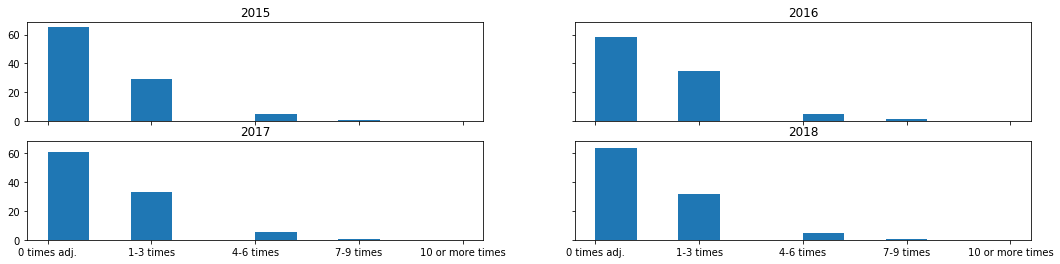

In [118]:
roughOptions = ["0 times adj.", "1-9 times", "10 or more times"]
fineOptions = ["0 times adj.", "1-3 times", "4-6 times", "7-9 times", "10 or more times"]

yearsWithData = [str(x) for x in range(2015,2019)]
#display([alcdf[bingeQs[0]].loc["2016", opt] for opt in roughOptions])

f, axs = plt.subplots(2, 2, sharey=True, sharex=True)
flatAxs = []
for x in axs:
    flatAxs.extend(x)
axs = flatAxs
for i, year in enumerate(yearsWithData):
    axs[i].set_title(year)
    axs[i].hist(fineOptions, weights=[float(alcdf[bingeQs[1]].replace("<0.7", 0.4/3).loc[year, opt]) for opt in fineOptions])
plt.show()
plt.close()

# fineEst = list(alcdf[bingeQs[1]]["Predicted Avg. Times"].loc["2015":"2018"])
sliceRoughEst = list(alcdf[bingeQs[0]]["Predicted Avg. Times"].loc["2015":"2018"])

def scaledDist(scalar):
    return distance.euclidean(fineEst, [x*scalar for x in sliceRoughEst])

scalar = optimize.minimize(scaledDist, 1)["x"][0]
print(scalar)
alcdf[bingeQs[0], "Adj. Predicted Avg. Times"] = alcdf[bingeQs[0]]["Predicted Avg. Times"] * scalar

ax = plt.gca()
#ax2 = ax.twinx()
for question in bingeQs:
    alcdf[question].loc[:, ["Predicted Avg. Times"]].plot(legend=True, ax=ax)
alcdf[bingeQs[0]]["Adj. Predicted Avg. Times"].plot(ax=ax, legend=True, style="r-.")
plt.show()

# good until here

Answer,15+,7.5 to 14,> 0 to 7,0,Blank,Total Responces,0 adj.
2012,5,12,44,38,1,583,39
2013,6,11,50,33,1,548,34
2014,4,11,47,37,0,438,37
2015,3,11,52,33,1,428,34
2016,5,11,56,27,1,902,28
2017,5,9,56,29,0.5,977,29.5
2018,5,8,56,11,20,825,31


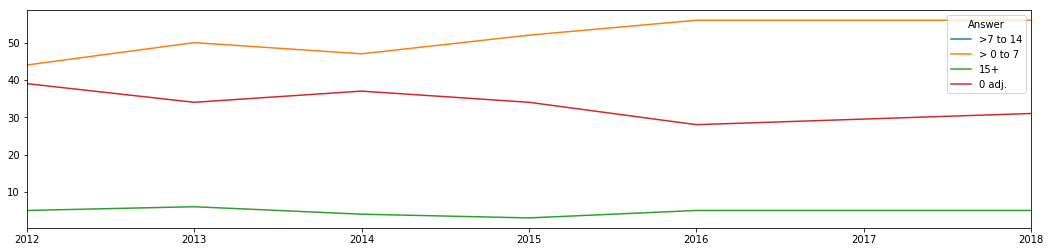

In [119]:
avgdrinkQ = "Average Number of Drinks per Week (%)"

#In 2018, the "Blank" figure includes people who did not receive the question because they were filtered out of the surveylogic as non-drinkers
alcdf[avgdrinkQ, "0 adj."] = alcdf[avgdrinkQ][0] + alcdf[avgdrinkQ]["Blank"]
display(alcdf[avgdrinkQ])
alcdf[avgdrinkQ].loc[:, [">7 to 14", "> 0 to 7", "15+", "0 adj."]].plot()

In [120]:
alcdf[avgdrinkQ, "Predicted Avg."] = (((alcdf[avgdrinkQ]["15+"]*70)+(alcdf[avgdrinkQ][">7 to 14"]*10.5)+(alcdf[avgdrinkQ]["> 0 to 7"]*3.5))/100)
display(alcdf[avgdrinkQ])
ax = plt.gca()
#alcdf[avgdrinkQ].loc[:, [">7 to 14", "> 0 to 7", "15+", "0 adj."]].plot(ax=ax)
alcdf[avgdrinkQ]["Predicted Avg."].plot(style="r-.", legend=True, ax=ax)#.twinx())
ax = plt.gca()
for question in bingeQs:
    alcdf[question].loc[:, ["1-9 times", "0 times adj.", "Predicted Avg. Times"]].plot(legend=True, style="--", ax=ax.twinx())
plt.show()

KeyError: '>7 to 14'

In [ ]:
covar=[]
for fifplus in range(0, 100):
    alcdf[avgdrinkQ, "Predicted Avg."] = (((alcdf[avgdrinkQ]["15+"]*fifplus)+(alcdf[avgdrinkQ][">7 to 14"]*10.5)+(alcdf[avgdrinkQ]["> 0 to 7"]*3.5))/100)
    covar.append(np.corrcoef(list(alcdf[avgdrinkQ]["Predicted Avg."]), 
                          list(alcdf[bingeQs[0]]["1-9 times"]))[0][1])
covar.index(max(covar))